In [2]:
print("""
@File         : 2-dataframe_ operations.ipynb
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2025-08-09 23:12:12
@Email        : cuixuanstephen@gmail.com
@Description  : Using DataFrame operations to enrich data
""")


@File         : 2-dataframe_ operations.ipynb
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2025-08-09 23:12:12
@Email        : cuixuanstephen@gmail.com
@Description  : Using DataFrame operations to enrich data



In [3]:
import pandas as pd
import numpy as np

weather = pd.read_csv('data/nyc_weather_2018.csv', parse_dates=["date"])

fb = pd.read_csv("data/fb_2018.csv", index_col="date", parse_dates=True)

In [4]:
fb.assign(
    abs_z_score_volume=lambda x: x["volume"].sub(x['volume'].mean()).div(x["volume"].std()).abs()
).query("abs_z_score_volume > 3")

,open,high,low,close,volume,abs_z_score_volume
date,,,,,,
2018-03-19,177.01,177.17,170.06,172.56,88140060,3.145078
2018-03-20,167.47,170.20,161.95,168.15,129851768,5.315169
2018-03-21,164.80,173.40,163.30,169.39,106598834,4.105413
2018-03-26,160.82,161.10,149.02,160.06,126116634,5.120845
2018-07-26,174.89,180.13,173.75,176.26,169803668,7.393705


In [5]:
fb.assign(
    volume_pct_change=fb["volume"].pct_change(),
    pct_change_rank=lambda x: x["volume_pct_change"].rank(ascending=False)
).nsmallest(5, "pct_change_rank")

,open,high,low,close,volume,volume_pct_change,pct_change_rank
date,,,,,,,
2018-01-12,178.06,181.48,177.40,179.37,77551299,7.087876,1.0
2018-03-19,177.01,177.17,170.06,172.56,88140060,2.611789,2.0
2018-07-26,174.89,180.13,173.75,176.26,169803668,1.628841,3.0
2018-09-21,166.64,167.25,162.81,162.93,45994800,1.428956,4.0
2018-03-26,160.82,161.10,149.02,160.06,126116634,1.352496,5.0


In [6]:
fb['2018-01-11': '2018-01-12']

,open,high,low,close,volume
date,,,,,
2018-01-11,188.40,188.40,187.38,187.77,9588587
2018-01-12,178.06,181.48,177.40,179.37,77551299


In [10]:
(fb > 215).any()

open       True
high       True
low       False
close      True
volume     True
dtype: bool

#### Binning

In [11]:
fb["volume"].is_unique

True

In [12]:
(fb["volume"].value_counts() > 1).sum()

0

In [13]:
volumed_binned = pd.cut(
    fb["volume"], bins=3, labels=["low", "med", "high"]
)

volumed_binned.value_counts()

volume
low     240
med       8
high      3
Name: count, dtype: int64

In [14]:
fb[volumed_binned == "high"].sort_values("volume", ascending=False)

,open,high,low,close,volume
date,,,,,
2018-07-26,174.89,180.13,173.75,176.26,169803668
2018-03-20,167.47,170.20,161.95,168.15,129851768
2018-03-26,160.82,161.10,149.02,160.06,126116634


In [16]:
fb["2018-07-25": "2018-07-26"]

,open,high,low,close,volume
date,,,,,
2018-07-25,215.715,218.62,214.27,217.50,64592585
2018-07-26,174.890,180.13,173.75,176.26,169803668


In [17]:
fb["2018-03-20": "2018-03-26"]

,open,high,low,close,volume
date,,,,,
2018-03-20,167.47,170.20,161.95,168.15,129851768
2018-03-21,164.80,173.40,163.30,169.39,106598834
2018-03-22,166.13,170.27,163.72,164.89,73742979
2018-03-23,165.44,167.10,159.02,159.39,53609706
2018-03-26,160.82,161.10,149.02,160.06,126116634


In [31]:
import matplotlib.pyplot as plt

def low_med_high_bins_viz(data, column, ylabel, title, figsize=(15, 3)):
    ax = data.plot(y=column, figsize=figsize, color="black", title=title)
    xlims = ax.get_xlim()
    
    for bin_name, hatch, bound in zip(
        ['low', 'med', 'high'],
        ['///', "", "\\\\\\"],
        pd.cut(data[column], bins=3).unique().categories.values
    ):
        plt.axhspan(bound.left, bound.right, alpha=.2, label=bin_name, hatch=hatch, color='black')
        plt.annotate(f"  {bin_name}", xy=(xlims[0], (bound.left + bound.right) / 2.1), ha='left')
        
        
    ax.set(xlabel="", ylabel=ylabel)
    plt.legend(bbox_to_anchor=(1, 0.75), frameon=False)
    
    return ax

<Axes: title={'center': 'Daily Volume Traded of Facebook Stock in 2018(with bins)'}, ylabel='volume traded'>

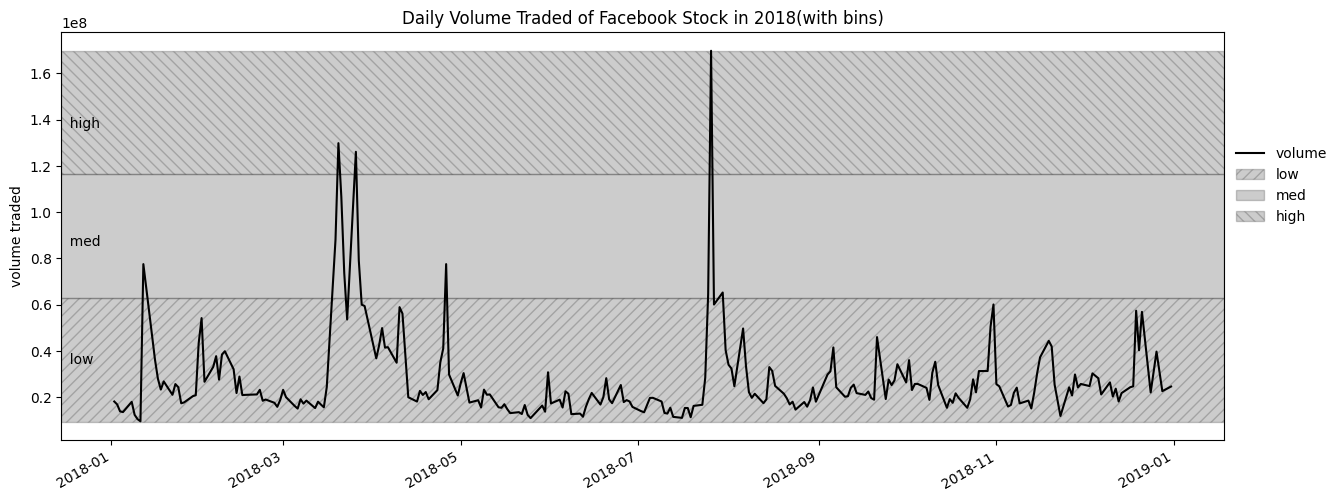

In [32]:
low_med_high_bins_viz(fb, 'volume', ylabel='volume traded',
                      title="Daily Volume Traded of Facebook Stock in 2018(with bins)",
                      figsize=(15, 6))

In [18]:
volumed_qbinned = pd.qcut(
    fb["volume"], q=4, labels=['q1', 'q2', 'q3', 'q4']
)

volumed_qbinned.value_counts()

volume
q1    63
q2    63
q4    63
q3    62
Name: count, dtype: int64

In [43]:
def quartile_bins_viz(data, column, ylabel, title, figsize=(15, 6)):
    ax = data.plot(y=column, figsize=figsize, color='black', title=title)
    
    xlims = ax.get_xlim()
    
    for bin_name, hatch, bounds in zip(
        [r"$Q_1$", r"$Q_2$", r"$Q_3$", r"$Q_4$"],
        ["\\\\\\", "", "///", "||||"],
        pd.qcut(data[column], q=4).unique().categories.values
    ):
        plt.axhspan(bounds.left, bounds.right, alpha=.2, label=bin_name, hatch=hatch, color='black')
        plt.annotate(f"  {bin_name}", xy=(xlims[0], (bounds.left + bounds.right) / 2.1), fontsize=11)
        
    ax.set(xlabel="", ylabel=ylabel)
    plt.legend(bbox_to_anchor=(1, 0.67), frameon=False, fontsize=14)
    
    return ax

<Axes: title={'center': 'Daily Volume Traded of Facebook Stock in 2018(with quartile bins)'}, ylabel='volume traded'>

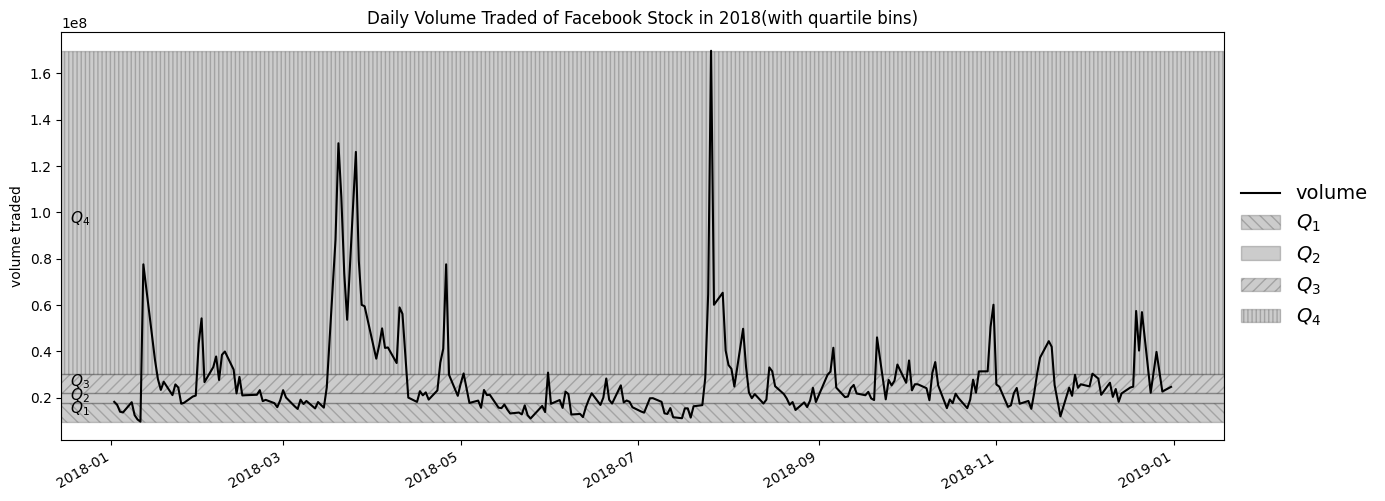

In [44]:
quartile_bins_viz(fb, 'volume', ylabel='volume traded', 
                  title="Daily Volume Traded of Facebook Stock in 2018(with quartile bins)")

#### Applying functions

In [47]:
central_park_weather = weather.query(
    "station == 'GHCND:USW00094728'"
).pivot(index="date", columns="datatype", values="value")

In [64]:
oct_weather_z_scores = central_park_weather.loc["2018-10", ["TMIN", "TMAX", "PRCP"]].apply(
    lambda x: x.sub(x.mean()).div(x.std())
)

oct_weather_z_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
datatype,,,,,,,,
TMIN,31.0,-1.790682e-16,1.0,-1.339112,-0.751019,-0.474269,1.065152,1.843511
TMAX,31.0,1.951844e-16,1.0,-1.305582,-0.870013,-0.138258,1.011643,1.604016
PRCP,31.0,4.655774e-17,1.0,-0.394438,-0.394438,-0.394438,-0.240253,3.936167


In [65]:
oct_weather_z_scores.query("PRCP > 3")

datatype,TMIN,TMAX,PRCP
date,,,
2018-10-27,-0.751019,-1.201045,3.936167


In [66]:
central_park_weather.loc["2018-10", "PRCP"].describe()

count    31.000000
mean      2.941935
std       7.458542
min       0.000000
25%       0.000000
50%       0.000000
75%       1.150000
max      32.300000
Name: PRCP, dtype: float64

In [67]:
import numpy as np

In [81]:
fb.apply(lambda x: np.vectorize(lambda y: len(str(np.ceil(y))))(x)
         ).astype('int64').equals(fb.map(lambda x: len(str(np.ceil(x)))))

True

In [ ]:
import time

np.random.seed(0)

vectorized_results = {}
iteritems_results = {}

for size in [10, 100, 1000, 1e4, 1e5, 5e5, 1e6, 5e6, 1e7]:
    size = int(size)
    test = pd.Series(np.random.uniform(size=size))
    
    start = time.time()
    x = test + 10
    end = time.time()
    vectorized_results[size] = end - start
    
    start = time.time()
    x = []
    for i, v in test.items():
        x.append(v + 10)
    x = pd.Series(x)
    end = time.time()
    
    iteritems_results[size] = end - start
    

results = pd.DataFrame(
    [pd.Series(vectorized_results, name='vectorized'), pd.Series(iteritems_results, name='iteritems')]
).T

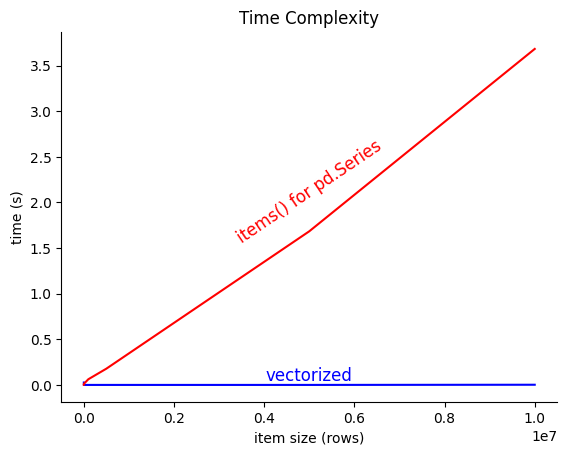

In [103]:
ax = results.plot(title="Time Complexity", color=["blue", "red"], legend=False)

ax.set(xlabel="item size (rows)", ylabel="time (s)")
ax.text(0.5e7, iteritems_results[0.5e7] * 0.9, 'items() for pd.Series', rotation=34,
        color='red', fontsize=12, ha='center', va='bottom')
ax.text(0.5e7, vectorized_results[0.5e7], 'vectorized', color='blue',
        fontsize=12, ha='center', va='bottom')

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

#### Window calculations

##### rolling windows

In [106]:
central_park_weather.loc["2018-10"].assign(
    rolling_PRCP=lambda x: x["PRCP"].rolling('3D').sum()
)[['PRCP', "rolling_PRCP"]].head(7).T

date,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07
datatype,,,,,,,
PRCP,0.0,17.5,0.0,1.0,0.0,0.0,0.0
rolling_PRCP,0.0,17.5,17.5,18.5,1.0,1.0,0.0


In [107]:
central_park_weather.loc["2018-10"].assign(
    rolling_PRCP=lambda x: x["PRCP"].rolling('3D').mean()
).head(7).iloc[:, :6]

datatype,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
date,,,,,,
2018-10-01,0.9,0.0,0.0,0.0,24.4,17.2
2018-10-02,0.9,17.5,0.0,0.0,25.0,18.3
2018-10-03,1.1,0.0,0.0,0.0,23.3,17.2
2018-10-04,0.4,1.0,0.0,0.0,24.4,16.1
2018-10-05,1.6,0.0,0.0,0.0,21.7,15.6
2018-10-06,0.5,0.0,0.0,0.0,20.0,17.2
2018-10-07,1.1,0.0,0.0,0.0,26.1,19.4


In [111]:
central_park_weather["2018-10-01": "2018-10-07"].rolling("3D").agg({
    "TMAX": 'max', "TMIN": "min", "AWND": 'mean', "PRCP": 'sum'
}).join(
    central_park_weather[["TMAX", "TMIN", "AWND", "PRCP"]],
    lsuffix='_rolling'
).sort_index(axis='columns')

datatype,AWND,AWND_rolling,PRCP,PRCP_rolling,TMAX,TMAX_rolling,TMIN,TMIN_rolling
date,,,,,,,,
2018-10-01,0.9,0.900000,0.0,0.0,24.4,24.4,17.2,17.2
2018-10-02,0.9,0.900000,17.5,17.5,25.0,25.0,18.3,17.2
2018-10-03,1.1,0.966667,0.0,17.5,23.3,25.0,17.2,17.2
2018-10-04,0.4,0.800000,1.0,18.5,24.4,25.0,16.1,16.1
2018-10-05,1.6,1.033333,0.0,1.0,21.7,24.4,15.6,15.6
2018-10-06,0.5,0.833333,0.0,1.0,20.0,24.4,17.2,15.6
2018-10-07,1.1,1.066667,0.0,0.0,26.1,26.1,19.4,15.6


In [113]:
fb_reindexed = fb.reindex(
    pd.date_range('2018-01-01', '2018-12-31', freq='D')
).assign(
    volume=lambda x: x["volume"].fillna(0),
    close=lambda x: x["close"].ffill(),
    open=lambda x: x['open'].combine_first(x['close']),
    high=lambda x: x['high'].combine_first(x['close']),
    low=lambda x: x['low'].combine_first(x['close']),
)

fb_reindexed.assign(day=lambda x: x.index.day_name()).head(10)

,open,high,low,close,volume,day
2018-01-01,NaN,NaN,NaN,NaN,0.0,Monday
2018-01-02,177.68,181.58,177.5500,181.42,18151903.0,Tuesday
2018-01-03,181.88,184.78,181.3300,184.67,16886563.0,Wednesday
2018-01-04,184.90,186.21,184.0996,184.33,13880896.0,Thursday
2018-01-05,185.59,186.90,184.9300,186.85,13574535.0,Friday
2018-01-06,186.85,186.85,186.8500,186.85,0.0,Saturday
2018-01-07,186.85,186.85,186.8500,186.85,0.0,Sunday
2018-01-08,187.20,188.90,186.3300,188.28,17994726.0,Monday
2018-01-09,188.70,188.80,187.1000,187.87,12393057.0,Tuesday
2018-01-10,186.94,187.89,185.6300,187.84,10529894.0,Wednesday


In [ ]:
from pandas.api.indexers import VariableOffsetWindowIndexer
# TODO
indexer = VariableOffsetWindowIndexer(
    index=fb_reindexed.index, offset=pd.offsets.BDay(3)
)

fb_reindexed.assign(window_start_day=0).rolling(indexer).agg({
    'window_start_day': lambda x: x.index.min().timestamp(),
    'open': 'mean', 'high': 'max', 'low': 'min',
    'close': 'mean', 'volume': 'sum'
}).join(
    fb_reindexed, lsuffix='_rolling'
).sort_index(axis='columns').assign(
    day=lambda x: x.index.day_name(),
    window_start_day=lambda x: pd.to_datetime(x['window_start_day'], unit='s')
).head(10)

,close,close_rolling,high,high_rolling,low,low_rolling,open,open_rolling,volume,volume_rolling,window_start_day,day
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2018-01-01,Monday
2018-01-02,181.42,181.420000,181.58,181.58,177.5500,177.5500,177.68,177.680000,18151903.0,18151903.0,2018-01-01,Tuesday
2018-01-03,184.67,183.045000,184.78,184.78,181.3300,177.5500,181.88,179.780000,16886563.0,35038466.0,2018-01-01,Wednesday
2018-01-04,184.33,183.473333,186.21,186.21,184.0996,177.5500,184.90,181.486667,13880896.0,48919362.0,2018-01-02,Thursday
2018-01-05,186.85,185.283333,186.90,186.90,184.9300,181.3300,185.59,184.123333,13574535.0,44341994.0,2018-01-03,Friday
2018-01-06,186.85,186.010000,186.85,186.90,186.8500,184.0996,186.85,185.780000,0.0,27455431.0,2018-01-04,Saturday
2018-01-07,186.85,186.220000,186.85,186.90,186.8500,184.0996,186.85,186.047500,0.0,27455431.0,2018-01-04,Sunday
2018-01-08,188.28,186.632000,188.90,188.90,186.3300,184.0996,187.20,186.278000,17994726.0,45450157.0,2018-01-04,Monday
2018-01-09,187.87,187.340000,188.80,188.90,187.1000,184.9300,188.70,187.038000,12393057.0,43962318.0,2018-01-05,Tuesday
2018-01-10,187.84,187.538000,187.89,188.90,185.6300,185.6300,186.94,187.308000,10529894.0,40917677.0,2018-01-06,Wednesday


##### Expanding Windows

In [123]:
central_park_weather.loc["2018-06"].assign(
    TOTAL_PRCP=lambda x: x['PRCP'].cumsum(),
    AVG_PRCP=lambda x: x['PRCP'].expanding().mean()
).head(10)[['PRCP', "TOTAL_PRCP", "AVG_PRCP"]].T

date,2018-06-01,2018-06-02,2018-06-03,2018-06-04,2018-06-05,2018-06-06,2018-06-07,2018-06-08,2018-06-09,2018-06-10
datatype,,,,,,,,,,
PRCP,6.9,2.00,6.4,4.10,0.00,0.000000,0.000000,0.000,0.000000,0.30
TOTAL_PRCP,6.9,8.90,15.3,19.40,19.40,19.400000,19.400000,19.400,19.400000,19.70
AVG_PRCP,6.9,4.45,5.1,4.85,3.88,3.233333,2.771429,2.425,2.155556,1.97


In [127]:
central_park_weather['2018-10-01': '2018-10-07'].expanding().agg({
    'TMAX': 'max', "TMIN": 'min', "AWND": 'mean', "PRCP": 'sum'
}).join(
    central_park_weather[['TMAX', 'TMIN', 'AWND', 'PRCP']],
    lsuffix='_expanding'
).sort_index(axis='columns')

datatype,AWND,AWND_expanding,PRCP,PRCP_expanding,TMAX,TMAX_expanding,TMIN,TMIN_expanding
date,,,,,,,,
2018-10-01,0.9,0.900000,0.0,0.0,24.4,24.4,17.2,17.2
2018-10-02,0.9,0.900000,17.5,17.5,25.0,25.0,18.3,17.2
2018-10-03,1.1,0.966667,0.0,17.5,23.3,25.0,17.2,17.2
2018-10-04,0.4,0.825000,1.0,18.5,24.4,25.0,16.1,16.1
2018-10-05,1.6,0.980000,0.0,18.5,21.7,25.0,15.6,15.6
2018-10-06,0.5,0.900000,0.0,18.5,20.0,25.0,17.2,15.6
2018-10-07,1.1,0.928571,0.0,18.5,26.1,26.1,19.4,15.6


##### Exponentially weighted moving windows

In [129]:
central_park_weather.assign(
    AVG=lambda x: x['TMAX'].rolling('30D').mean(),
    EWMA=lambda x: x['TMAX'].ewm(span=30).mean()
).loc["2018-09-29": '2018-10-08', ["TMAX", 'EWMA', 'AVG']].T

date,2018-09-29,2018-09-30,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07,2018-10-08
datatype,,,,,,,,,,
TMAX,22.200000,21.100000,24.400000,25.000000,23.300000,24.400000,21.700000,20.000000,26.100000,23.300000
EWMA,24.410887,24.197281,24.210360,24.261304,24.199285,24.212234,24.050154,23.788854,23.937960,23.896802
AVG,24.723333,24.573333,24.533333,24.460000,24.163333,23.866667,23.533333,23.070000,23.143333,23.196667


#### Pipes

In [130]:
def get_info(df):
    return "%d rows, %d cols and max closing Z-score: %d" % (*df.shape, df["close"].max())

In [131]:
get_info(fb.loc["2018-Q1"].apply(lambda x: (x - x.mean()) / x.std()))

'61 rows, 5 cols and max closing Z-score: 1'

In [132]:
fb.loc["2018-Q1"].apply(lambda x: (x - x.mean()) / x.std()).pipe(get_info)

'61 rows, 5 cols and max closing Z-score: 1'

In [133]:
fb.pipe(pd.DataFrame.rolling, '20D').mean().equals(
    fb.rolling('20D').mean()
)

True

In [134]:
from window_calc import window_calc

In [135]:
window_calc??

Signature: window_calc(df, func, agg_dict, *args, **kwargs)
Source:   
def window_calc(df, func, agg_dict, *args, **kwargs):
    """
    Run a window calculation of your choice on a `DataFrame` object.

    Parameters:
        - df: The `DataFrame` object to run the calculation on.
        - func: The window calculation method that takes `df`
          as the first argument.
        - agg_dict: Information to pass to `agg()`, could be a
          dictionary mapping the columns to the aggregation
          function to use, a string name for the function,
          or the function itself.
        - args: Positional arguments to pass to `func`.
        - kwargs: Keyword arguments to pass to `func`.

    Returns:
        A new `DataFrame` object.
    """
    return df.pipe(func, *args, **kwargs).agg(agg_dict)
File:      d:\hands-on-data-analysis-with-pandas\ch04_aggregating\window_calc.py
Type:      function


In [137]:
window_calc(fb, pd.DataFrame.expanding, 'median')

,open,high,low,close,volume
date,,,,,
2018-01-02,177.680,181.580,177.5500,181.420,18151903.0
2018-01-03,179.780,183.180,179.4400,183.045,17519233.0
2018-01-04,181.880,184.780,181.3300,184.330,16886563.0
2018-01-05,183.390,185.495,182.7148,184.500,15383729.5
2018-01-08,184.900,186.210,184.0996,184.670,16886563.0
...,...,...,...,...,...
2018-12-24,175.300,177.110,172.9900,175.730,21785820.0
2018-12-26,175.215,177.105,172.9550,175.310,21797585.0
2018-12-27,175.130,177.100,172.9200,174.890,21809350.0


In [138]:
window_calc(fb, pd.DataFrame.ewm, 'mean', span=3).head()

,open,high,low,close,volume
date,,,,,
2018-01-02,177.680000,181.580000,177.550000,181.420000,1.815190e+07
2018-01-03,180.480000,183.713333,180.070000,183.586667,1.730834e+07
2018-01-04,183.005714,185.140000,182.372629,184.011429,1.534980e+07
2018-01-05,184.384000,186.078667,183.736560,185.525333,1.440299e+07
2018-01-08,185.837419,187.534839,185.075110,186.947097,1.625679e+07


In [141]:
window_calc(central_park_weather.loc['2018-10'],
            pd.DataFrame.rolling,
            {'TMAX': 'max', "TMIN": "min", "AWND": 'mean', "PRCP": "sum"},
            '3D').head()

datatype,TMAX,TMIN,AWND,PRCP
date,,,,
2018-10-01,24.4,17.2,0.900000,0.0
2018-10-02,25.0,17.2,0.900000,17.5
2018-10-03,25.0,17.2,0.966667,17.5
2018-10-04,25.0,16.1,0.800000,18.5
2018-10-05,24.4,15.6,1.033333,1.0
